In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import openpyxl

In [2]:
def load_data(data_path):
    points = []
    f = open('data/' + data_path)               # 返回一个文件对象
    line = f.readline()               # 调用文件的 readline()方法
    while line:
        data = line.split(' ')
        while '' in data:
            data.remove('')
        while ' ' in data:
            data.remove(' ')
        point = []
        for j in range(3,5):
            point.append(float(data[j]))
        line = f.readline()
        points.append(point)
    f.close()
    return points

In [3]:
def load_excel_data(file):
    points = []
    import_path = 'data/' + file
    wb = openpyxl.load_workbook(import_path)
    ws = wb.active
    datatmp = []
    for i in range(2,ws.max_row+1):
        rowtmp = []
        for j in range(4,ws.max_column+1):
            celltmp=ws.cell(row = i, column = j).value
            try:
                rowtmp.append(celltmp)
            except:
                continue
        points.append(rowtmp)
    return np.array(points) 

In [4]:
# 调用线性回归模型并在 ax 上绘图(数据处理)
def regression(ts,Ts,ax,fig):
    print(len(ts)); print(len(Ts))
    lr = LinearRegression()
    ts = np.array(ts).reshape(-1, 1); Ts = np.array(Ts).reshape(-1,1)
    
    lr.fit(ts,Ts) # 训练模型
        
    length = np.max(ts) - np.min(ts)
    min_1 = np.min(ts) - (length*1000)**0.4; max_1 = np.max(ts) + (length*800)**0.4
    ts_hat = np.row_stack((ts,[min_1]))
    ts_hat = np.row_stack((ts_hat,[max_1])); 
    Ts_hat = lr.predict(ts_hat) # 计算 Ts_hat
        
    average = np.average(Ts_hat) # 稳定时的温度
    if average >= 5.0:
        c = 'r'
    if average < 5.0:
        c = 'b'
    
    target_point = ax.scatter(ts, Ts, c=c, s=30, alpha=0.6, edgecolors='none')
    plt.legend([target_point],['selected points'], fontsize=24)
    ax.plot(ts_hat, Ts_hat, c=c, alpha =0.6, linewidth=1)
    
    left, width = 0.1, 1; bottom, height = 0.1, 1; spacing = 0.1
    rect_text = [left + width*0.55, bottom+height*0.6]
    text = 'Temperature is ' + str(format(average, '.4f'))
    ax.annotate(text, xy=(np.average(ts), np.average(Ts)), xytext=(np.average(ts)-0.3,
            np.average(Ts)+0.09),color=c,fontsize=24, arrowprops=dict(facecolor=c, shrink=0.05))
    
    return average

In [5]:
def find_Tminmax(ts, Ts, flatrate, tolerance, trim, ax, fig):
    count = 0; flag = False; current_ts = []; current_Ts = []; min_Ts = []; max_Ts = []
    # print('len(ts): ');print(len(ts))
    for i in range(len(ts)-8):
        dT = (abs(Ts[i+7]-Ts[i+6]) + abs(Ts[i+5]-Ts[i+4]) + abs(Ts[i+3]-Ts[i+2]) + abs(Ts[i+1]-Ts[i]))/4
            #(Ts[i+7] + Ts[i+5] + Ts[i+3] + Ts[i+1] - Ts[i+6] - Ts[i+4] - Ts[i+2] - Ts[i])/4
        if (abs(dT) <= flatrate) & (count <= tolerance):
            count = count + 1
        if (abs(dT) > flatrate) & (count>=1):
            count = count - 1
        if abs(dT) > flatrate*30:
            current_ts = []; current_Ts = []; count = 0; flag = False
        
        if count >= tolerance:
            flag = True
        if count < tolerance:
            flag = False
        
        if flag:
            current_ts.append(ts[i]); current_Ts.append(Ts[i])
        else:
            if len(current_Ts) >= tolerance+trim*2:
                current_ts = current_ts[trim:-trim]; current_Ts = current_Ts[trim:-trim]
                average = regression(current_ts,current_Ts,ax,fig)
                if average >= 5:
                    max_Ts.append(average)
                else:
                    min_Ts.append(average)
                # print('current_ts:'); print(current_ts)
                current_ts = []; current_Ts = []; count = 0
        
        ## 以下的代码解决末尾的符合要求值无法输出的 bug
    if len(current_Ts) >= tolerance+trim*2:
        current_ts = current_ts[trim:-trim]; current_Ts = current_Ts[trim:-trim]
        average = regression(current_ts,current_Ts,ax,fig)
        if average >= 5:
            max_Ts.append(average)
        else:
            min_Ts.append(average)
        
    return min_Ts, max_Ts

17
17
236
236


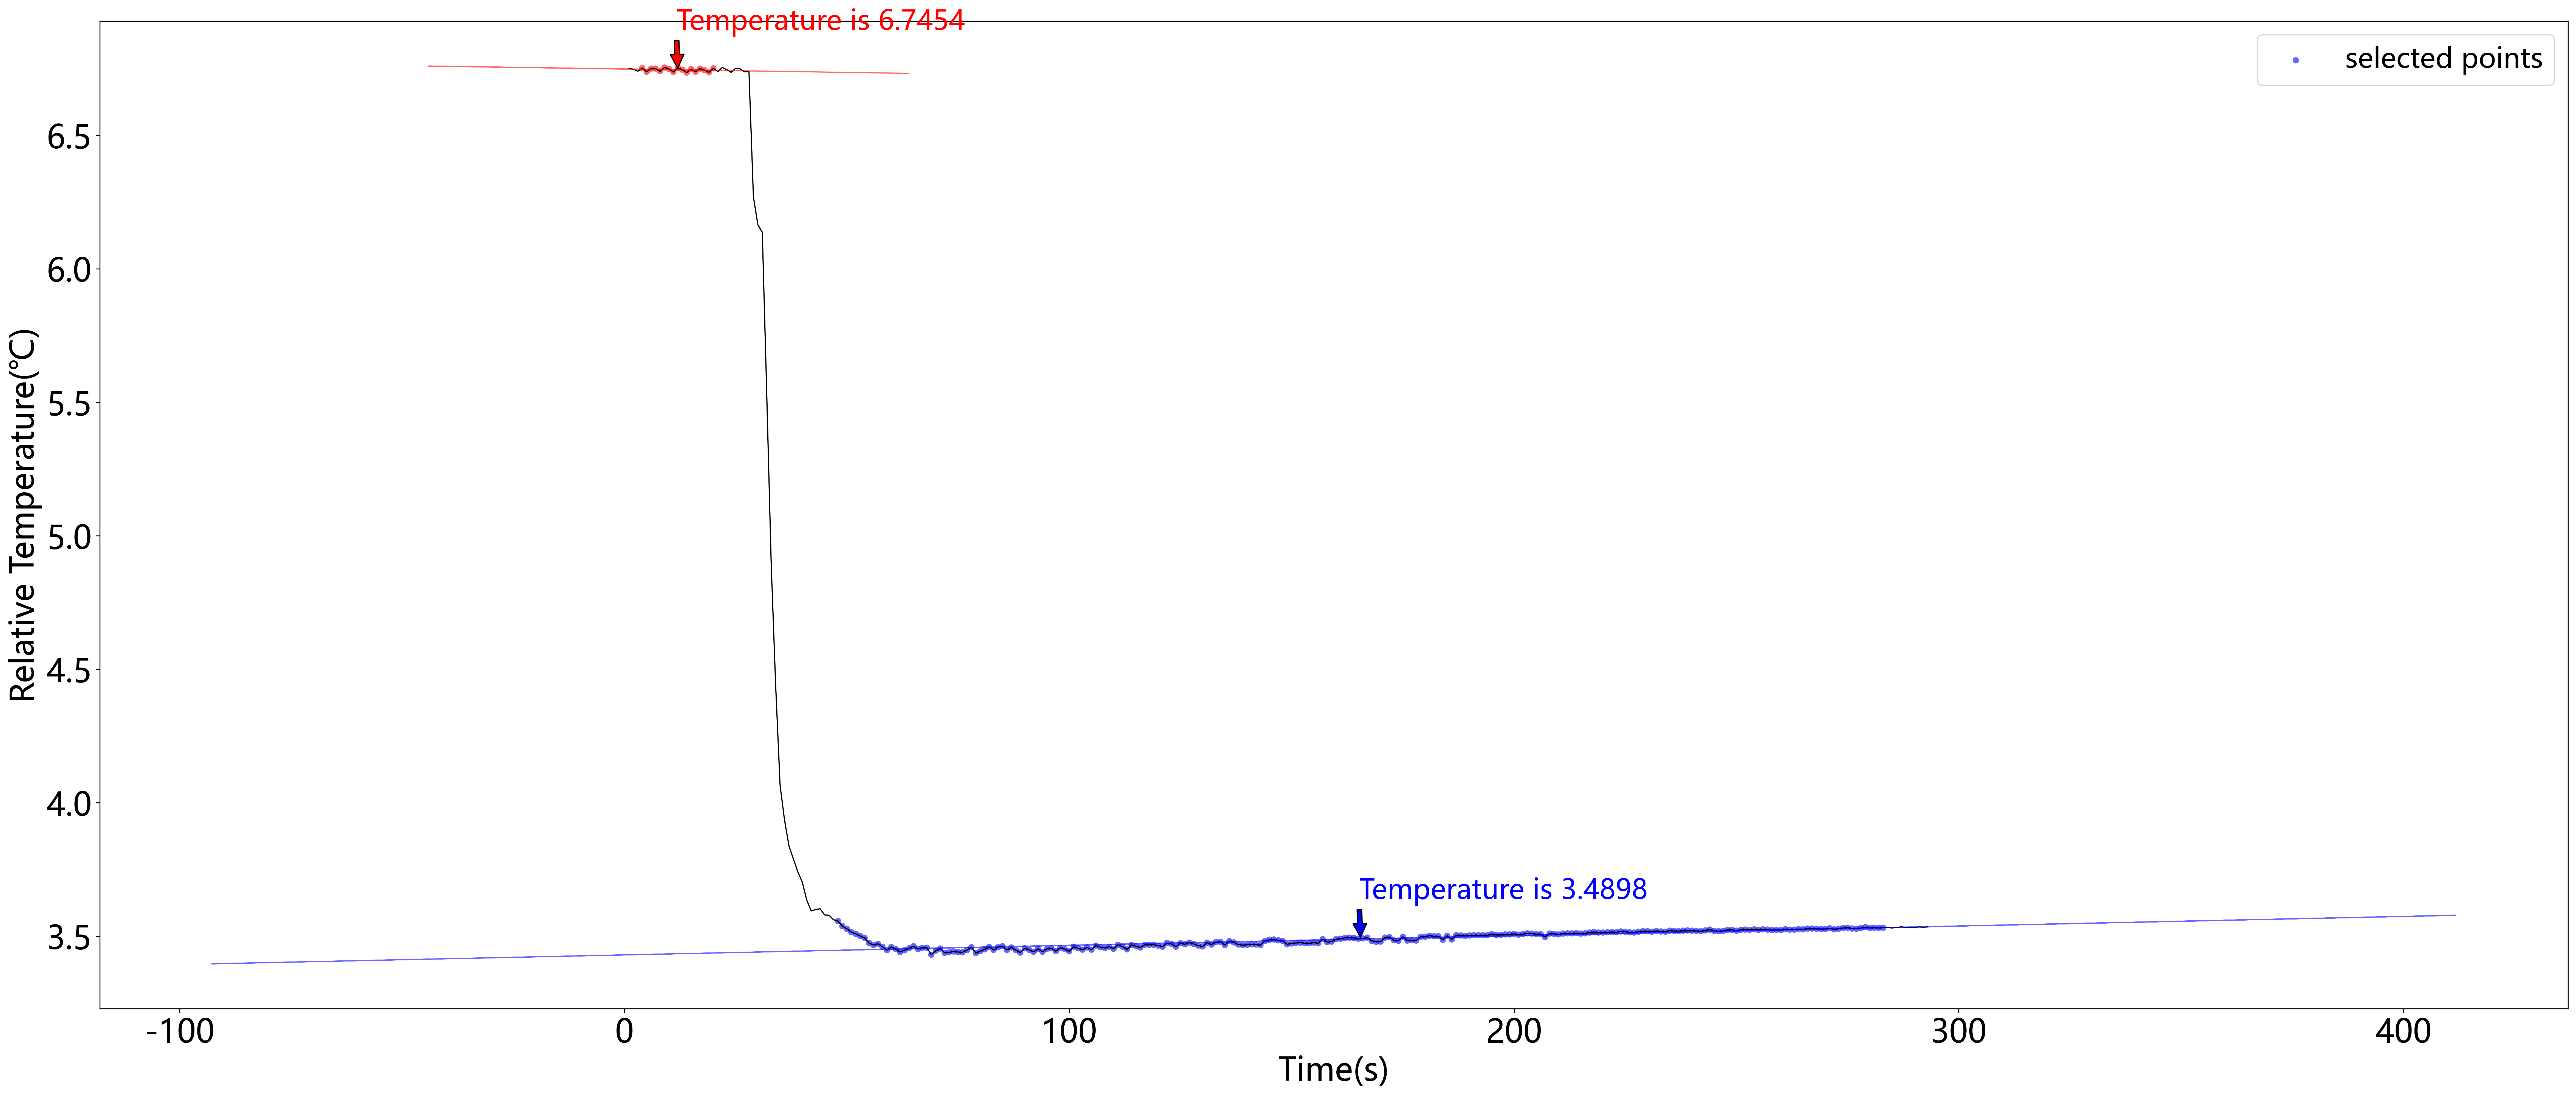

In [11]:
name = '5_00.xlsx'#'总数据_678876'
points = load_excel_data(name)
ts = np.array(points).T[0]; Ts = np.array(points).T[1]

#data = pd.DataFrame(Ts, ts, columns=["温度"])
#data = data.rolling(7).mean()

plt.rcParams['figure.figsize'] = (20.0, 10.0) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.rcParams['font.size'] = 28 #字体大小

left, width = 0.1, 1; bottom, height = 0.1, 1; spacing = 0.1
rect = [left*0, bottom, width, height]; rect_text = [left + width*0.55, bottom+height*0.7]
fig = plt.figure(figsize=(30,12))
ax = fig.add_axes(rect)

ax.plot(ts, Ts, c='k', linewidth=1)
ax.set_xlabel('Time(s)'); ax.set_ylabel('Relative Temperature(℃)')

min_Ts, max_Ts = find_Tminmax(ts, Ts, flatrate=0.015, tolerance=2, trim=2, ax=ax, fig=fig)

plt.savefig('溶解焓数据处理.png',bbox_inches='tight')

In [8]:
print(max_Ts); print(min_Ts)

[6.745800800601708]
[3.490161097217365]
